# **Loading Dataset**

In [ ]:
!wget http://images.cocodataset.org/zips/val2017.zip
!unzip val2017.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip annotations_trainval2017.zip

Streaming output truncated to the last 5000 lines.
 extracting: val2017/000000577584.jpg  
 extracting: val2017/000000346905.jpg  
 extracting: val2017/000000433980.jpg  
 extracting: val2017/000000228144.jpg  
 extracting: val2017/000000041872.jpg  
 extracting: val2017/000000117492.jpg  
 extracting: val2017/000000368900.jpg  
 extracting: val2017/000000376900.jpg  
 extracting: val2017/000000352491.jpg  
 extracting: val2017/000000330790.jpg  
 extracting: val2017/000000384850.jpg  
 extracting: val2017/000000032735.jpg  
 extracting: val2017/000000197004.jpg  
 extracting: val2017/000000526751.jpg  
 extracting: val2017/000000041488.jpg  
 extracting: val2017/000000153632.jpg  
 extracting: val2017/000000501523.jpg  
 extracting: val2017/000000405691.jpg  
 extracting: val2017/000000040757.jpg  
 extracting: val2017/000000219485.jpg  
 extracting: val2017/000000428280.jpg  
 extracting: val2017/000000209222.jpg  
 extracting: val2017/000000353051.jpg  
 extracting: val2017/00000019

# **Loading Model**

In [ ]:
device='cuda'

In [ ]:
import torch
import torchvision

model = torchvision.models.detection.retinanet_resnet50_fpn_v2(pretrained=True).to(device)
model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RetinaNet_ResNet50_FPN_V2_Weights.COCO_V1`. You can also use `weights=RetinaNet_ResNet50_FPN_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

# **Helper Functions**

In [ ]:
from torchvision.datasets import CocoDetection

coco = CocoDetection(root='/content/val2017',
                     annFile='/content/annotations/instances_val2017.json')

loading annotations into memory...
Done (t=0.67s)
creating index...
index created!


In [ ]:
from torchvision import transforms

def preprocess(image):
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    return transform(image)

In [ ]:
from pycocotools.coco import COCO
from torchvision.utils import draw_bounding_boxes
import matplotlib.pyplot as plt
import numpy as np
import cv2

def predictAndPlot(model, image, image_id):
    with torch.no_grad():
        image_tensor = preprocess(image).unsqueeze(0)
        imgCopy=torch.tensor(255*(preprocess(image)),dtype=torch.uint8)
        predictions = model(image_tensor.to(device))
        
    scores = predictions[0]['scores'].cpu().numpy()
    boxes = predictions[0]['boxes'].cpu().numpy()
    labels = predictions[0]['labels'].cpu().numpy()

    bbImg=draw_bounding_boxes(imgCopy,predictions[0]['boxes'][predictions[0]['scores']>0.7],width=8)
    plt.imshow(bbImg.permute(1,2,0))
    plt.show()
    
    result = []
    for score, box, label in zip(scores, boxes, labels):
        x1, y1, x2, y2 = box

        if(score>=0.5):

          result.append({
              'image_id': image_id,
              'category_id': label,
              'bbox': [x1, y1, x2 - x1, y2 - y1],
              'score': score
          })
    
    return result

def predict(model, image, image_id):
    with torch.no_grad():
        image_tensor = preprocess(image).unsqueeze(0)
        predictions = model(image_tensor.to(device))
        
    scores = predictions[0]['scores'].cpu().numpy()
    boxes = predictions[0]['boxes'].cpu().numpy()
    labels = predictions[0]['labels'].cpu().numpy()
    
    result = []
    for score, box, label in zip(scores, boxes, labels):
        x1, y1, x2, y2 = box

        if(score>=0.7):

          result.append({
              'image_id': image_id,
              'category_id': label,
              'bbox': [x1, y1, x2 - x1, y2 - y1],
              'score': score
          })
    
    return result

# **Inference on val2017 split (5k images)**

In [ ]:
from tqdm import tqdm
results = []
imageIds=[]
for i in tqdm(range(len(coco))):
  image, target = coco[i]
  imgId=coco.ids[i]
  imageIds.append(imgId)
  result = predict(model, image, imgId)
  results.extend(result)
    
print(results)

100%|██████████| 5000/5000 [11:03<00:00,  7.53it/s]

[{'image_id': 139, 'category_id': 72, 'bbox': [4.7427516, 165.69733, 151.11955, 97.82651], 'score': 0.8953427}, {'image_id': 139, 'category_id': 82, 'bbox': [450.35104, 170.08345, 61.89267, 120.510574], 'score': 0.81805474}, {'image_id': 139, 'category_id': 62, 'bbox': [293.38614, 220.03159, 58.54059, 95.45102], 'score': 0.76342994}, {'image_id': 139, 'category_id': 1, 'bbox': [419.477, 157.38979, 44.37375, 139.73671], 'score': 0.74897623}, {'image_id': 285, 'category_id': 23, 'bbox': [0.0, 68.37166, 584.4021, 561.5145], 'score': 0.99404514}, {'image_id': 632, 'category_id': 65, 'bbox': [0.0, 275.04984, 399.8024, 202.24292], 'score': 0.92002845}, {'image_id': 632, 'category_id': 64, 'bbox': [335.78992, 215.29007, 93.92386, 135.99341], 'score': 0.8774894}, {'image_id': 632, 'category_id': 64, 'bbox': [189.56255, 131.31749, 56.340607, 97.869385], 'score': 0.7235543}, {'image_id': 724, 'category_id': 13, 'bbox': [119.84931, 69.74257, 135.1101, 155.66937], 'score': 0.99982256}, {'image_id'

# **Evaluation**

In [ ]:
from pycocotools.cocoeval import COCOeval

coco_gt = COCO('/content/annotations/instances_val2017.json')

coco_results = coco_gt.loadRes(results)
coco_eval = COCOeval(coco_gt, coco_results, iouType='bbox')
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()

loading annotations into memory...
Done (t=0.67s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=11.80s).
Accumulating evaluation results...
DONE (t=1.84s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.253
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.328
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.283
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.082
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.273
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.406
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.221
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.273
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

# **Visual Samples**

<ipython-input-16-f613b3a795db>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  imgCopy=torch.tensor(255*(preprocess(image)),dtype=torch.uint8)


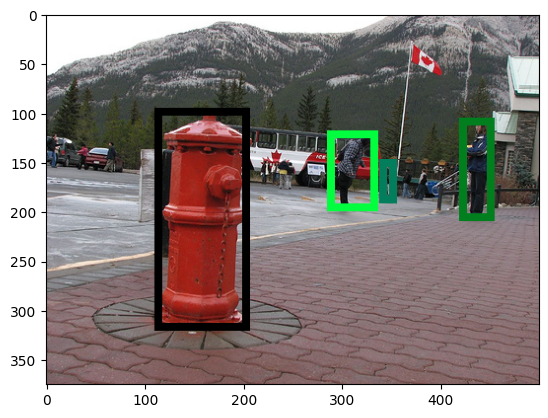

In [ ]:
idx=896
image, target = coco[idx]
imgId=target[0]['image_id']
imageIds.append(imgId)
result = predictAndPlot(model, image, imgId)

<ipython-input-16-f613b3a795db>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  imgCopy=torch.tensor(255*(preprocess(image)),dtype=torch.uint8)


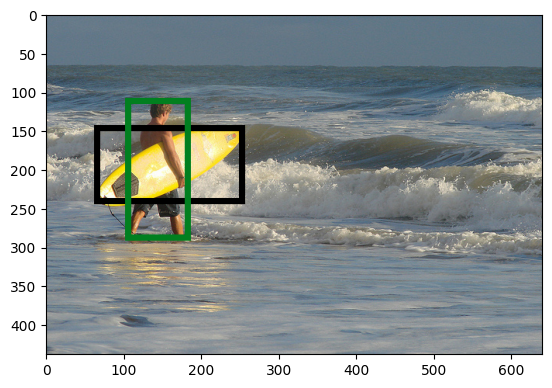

In [ ]:
idx=467
image, target = coco[idx]
imgId=target[0]['image_id']
imageIds.append(imgId)
result = predictAndPlot(model, image, imgId)

<ipython-input-16-f613b3a795db>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  imgCopy=torch.tensor(255*(preprocess(image)),dtype=torch.uint8)


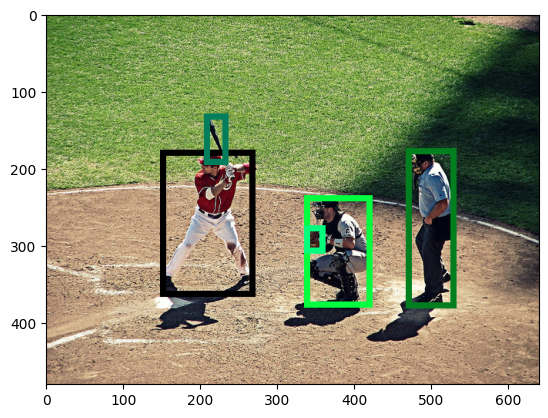

In [ ]:
idx=408
image, target = coco[idx]
imgId=target[0]['image_id']
imageIds.append(imgId)
result = predictAndPlot(model, image, imgId)

<ipython-input-16-f613b3a795db>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  imgCopy=torch.tensor(255*(preprocess(image)),dtype=torch.uint8)


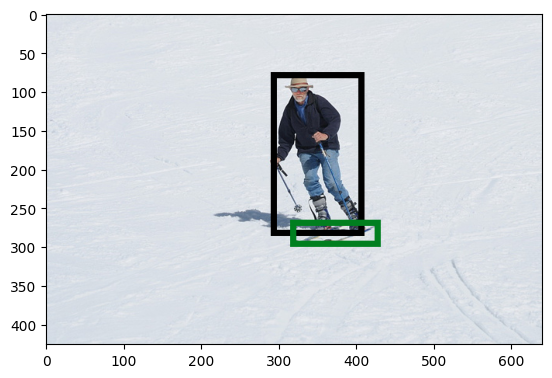

In [ ]:
idx=850
image, target = coco[idx]
imgId=target[0]['image_id']
imageIds.append(imgId)
result = predictAndPlot(model, image, imgId)